## Import libraries

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from fastdtw import fastdtw
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

In [2]:
plt.rcParams["figure.figsize"] = (16, 12) # (w, h)

## Load video and get first frame

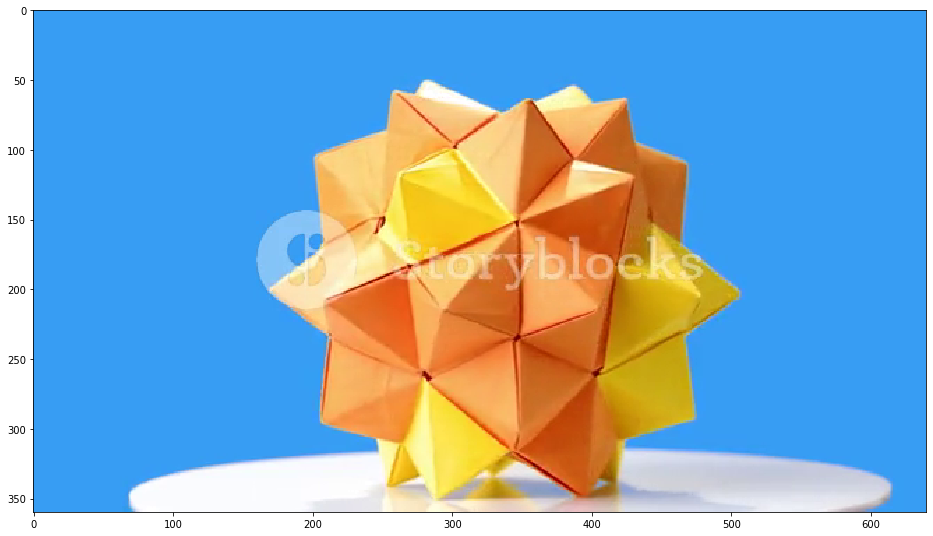

In [3]:
vid = cv2.VideoCapture("imgs/example.mp4")

# 260 is a very symmetric frame
# 132 is not a very symmetric frame
for i in range(46):
    is_good, img = vid.read()
img = img[...,::-1] #Convert BGR to RGB order

plt.imshow(img);

## View the reg green and blue channels

Notice the blue channel has high (yellow) values for the background and low (blue/purple) values for the foreground. The Red channel has the opposite.

(360, 640, 3)


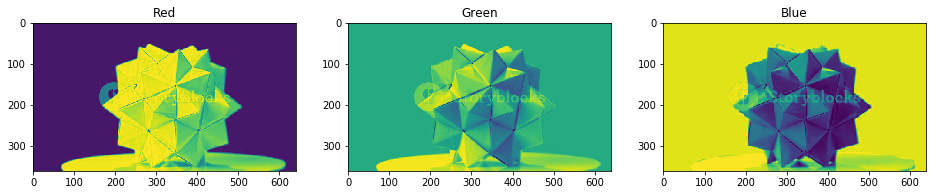

In [4]:
#while is_good:
im_R = img[...,0]
im_G = img[...,1]
im_B = img[...,2]

print(img.shape)

plt.subplot(131);
plt.imshow(im_R); #R
plt.title("Red");
plt.subplot(132);
plt.imshow(im_G); #G
plt.title("Green");
plt.subplot(133);
plt.imshow(im_B); #B
plt.title("Blue");

## Make histogram of pixel colours to set thresholds

We can see that there are spikes in red around 50, and blue around 240.

Note: The charts are log scale.

/home/matt/.local/lib/python3.6/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


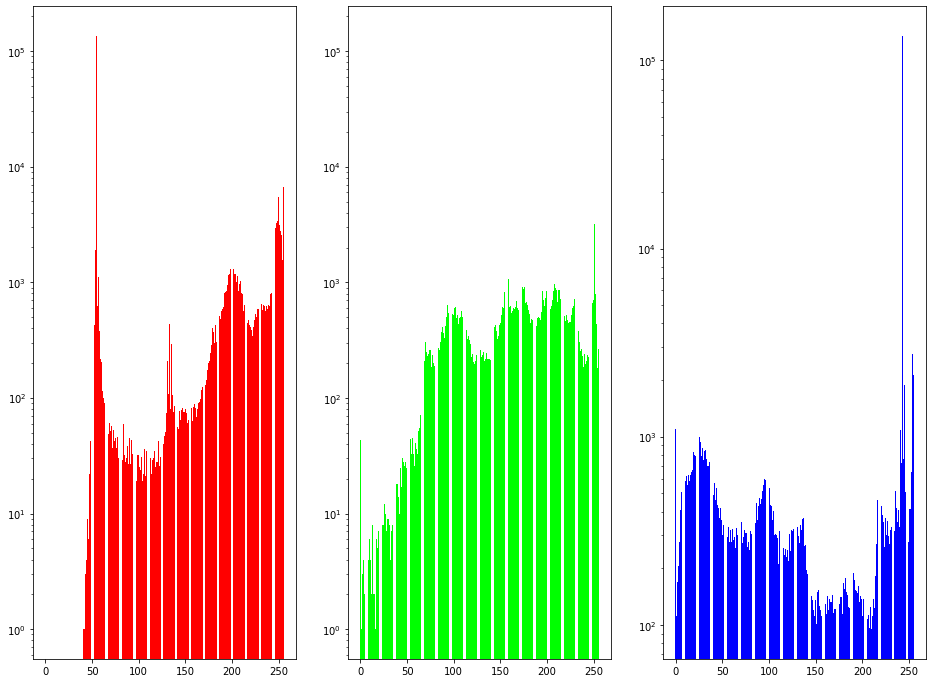

In [5]:
def log_hist(data, colour, ax=None):
    hist_d = cv2.calcHist([data],[0],None,[256],[0,256]).reshape(-1)
    if ax is None:
        log_hist = np.log(hist_d)
        log_hist[hist_d == 0] = 0
        plt.bar(range(len(log_hist)), log_hist, color=colour)
    else:
        plt.bar(range(len(hist_d)), hist_d, color=colour)
        ax.set_yscale('log')

ax = plt.subplot(131)
log_hist(im_R, (1,0,0), ax=ax)
ax = plt.subplot(132)
log_hist(im_G, (0,1,0), ax=ax)
ax = plt.subplot(133)
log_hist(im_B, (0,0,1), ax=ax)

## Use thresholds to make a foreground mask
In this case we use any red values above below 155 as background, and any blue values above 210 as background.

logical and them together to see the result.

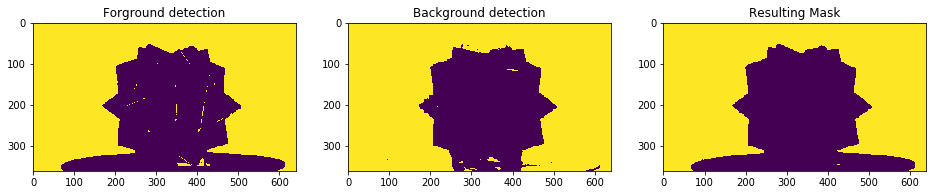

In [6]:
m1 = im_R < 155
m2 = im_B > 210
mask = np.logical_and(m1, m2)

plt.subplot(131);
plt.imshow(m1);
plt.title("Forground detection");
plt.subplot(132);
plt.imshow(m2);
plt.title("Background detection");
plt.subplot(133);
plt.imshow(mask);
plt.title("Resulting Mask");

mask = mask.astype(np.uint8)*255

## Use morphological operations to clean up mask and remove holes

Here we use a close then an open to clean up the background and foreground respectively.
Read more [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) about mophological opertions.

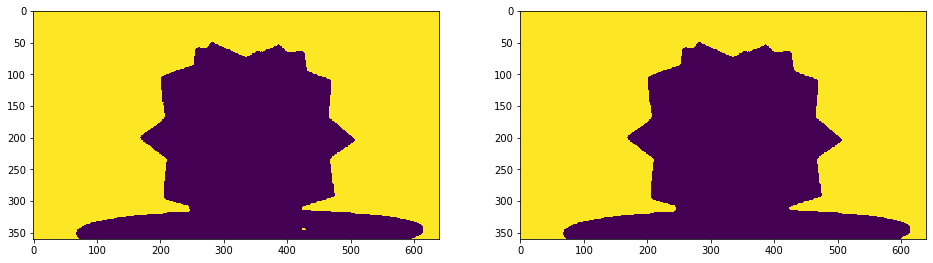

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.subplot(121);
plt.imshow(closed);
plt.subplot(122);
plt.imshow(opened);

## Find contours of mask and approximate a polygon and overlay on image

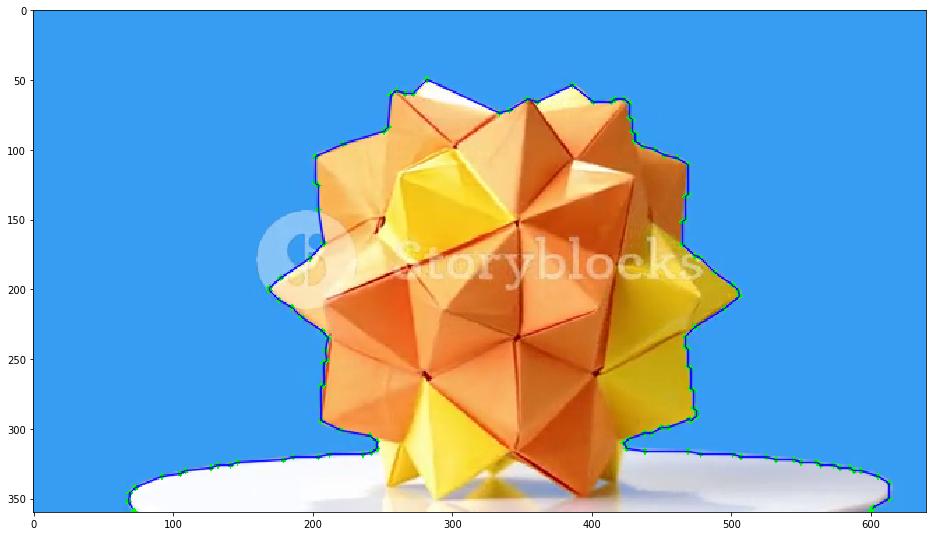

In [8]:
# get mask contours
cnts = cv2.findContours(255 - opened,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)[-2]

#get largest contour
cnt = sorted(cnts, key=cv2.contourArea)[-1]

# calc arclentgh
arclen = cv2.arcLength(cnt, True)

# do polygon approx
eps = 0.0005
epsilon = arclen * eps
approx = cv2.approxPolyDP(cnt, epsilon, True)

# draw the result
canvas = img.copy()
for pt in approx:
    cv2.circle(canvas, (pt[0][0], pt[0][1]), 2, (0,255,0), -1)

cv2.drawContours(canvas, [approx], -1, (0,0,255), 1, cv2.LINE_AA)

plt.imshow(canvas);

## Scatter plot points with midline

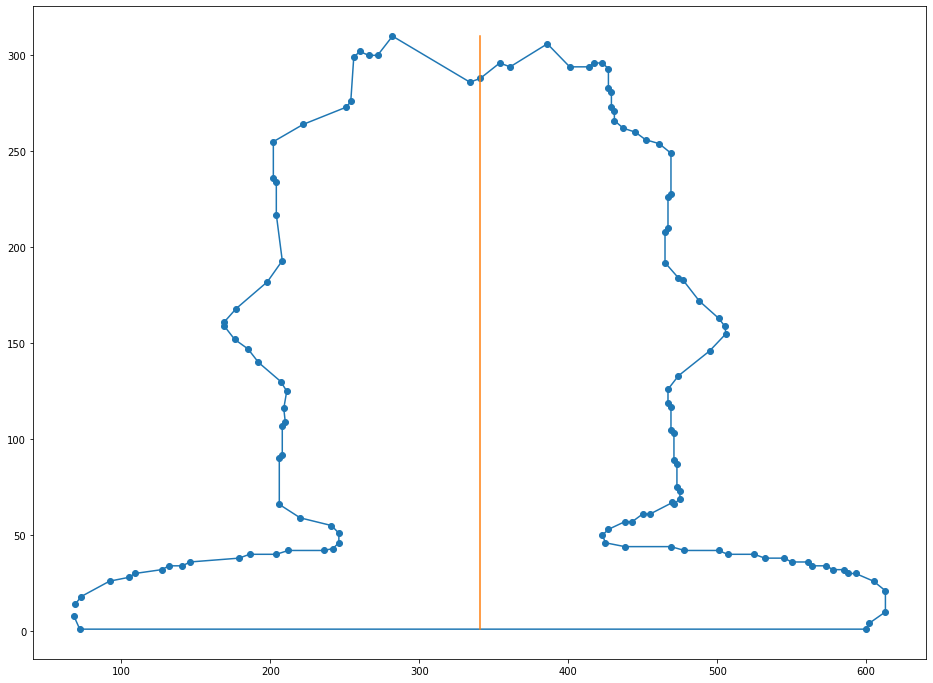

In [9]:
points = approx[:,0].copy()
# y axis is flipped in image space
points[:,1] = img.shape[0] - points[:,1]

max_x, max_y = np.max(points, axis=0)
min_x, min_y = np.min(points, axis=0)

mid_x = (max_x + min_x)/2

plt.plot(points[:,0], points[:,1], "-o"); 
plt.plot([mid_x, mid_x], [min_y, max_y]);

## Mirror and find match between original
This can be greatly improved. The matching algorithm will change the score drastically. 

This naively matches the start and end points based on distance. We then use a diferentiable version of [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) for iteratively matching the two sequences and finding an optimal translation to line up the reflection.

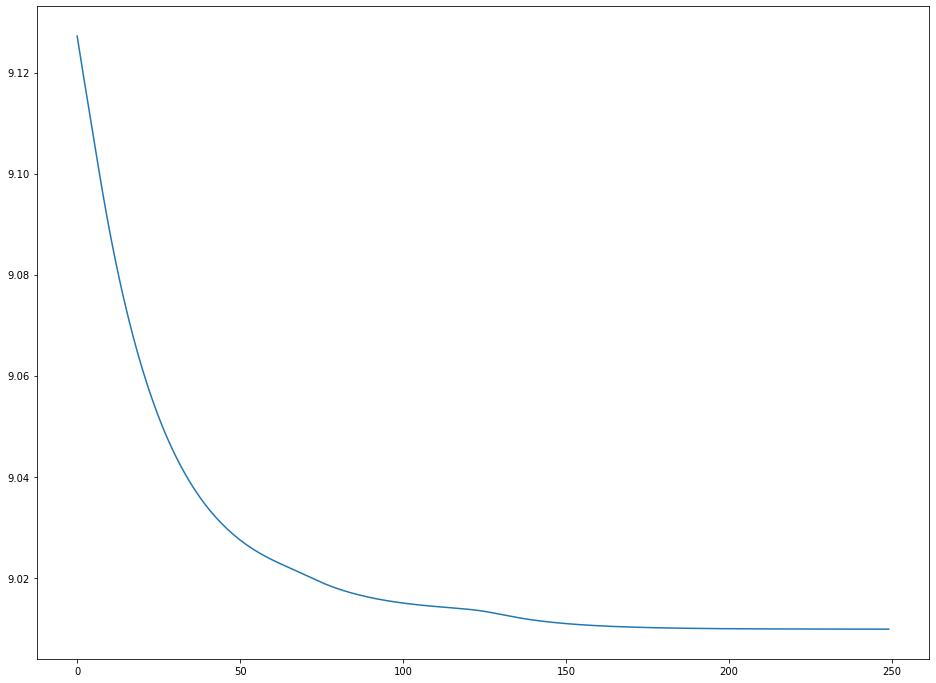

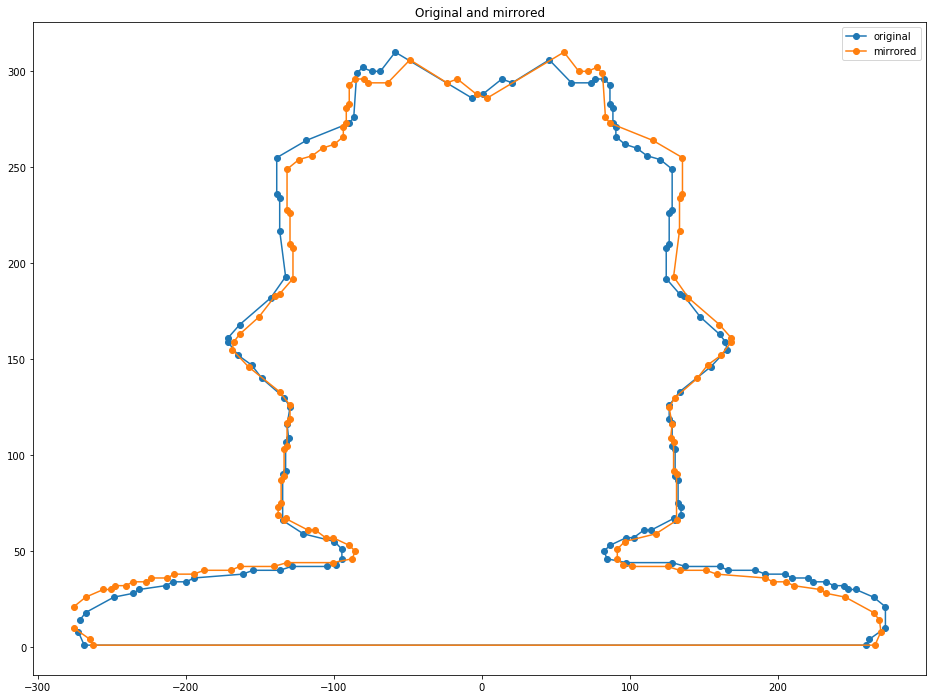

In [10]:

points_centered = points - [mid_x, 0]
flipped = points_centered.copy()
flipped[:,0] = -flipped[:,0]

errors = []
for i in range(len(flipped)):
    start = flipped[i]
    end = flipped[(i + 1) % len(flipped)]
    errors.append(np.linalg.norm(points_centered[0] - start) +
                  np.linalg.norm(np.linalg.norm(points_centered[-1] - end)))

# plt.plot(errors)
min_i = np.argmin(errors) + 1
flipped = np.flip(np.concatenate([flipped[min_i:], flipped[:min_i]]), 0)

def get_grad(X,Y):
    # D can also be an arbitrary distance matrix: numpy array, shape [m, n]
    D = SquaredEuclidean(X,Y)
    sdtw = SoftDTW(D, gamma=1.0)
    # soft-DTW discrepancy, approaches DTW as gamma -> 0
    value = sdtw.compute()
    # gradient w.r.t. D, shape = [m, n], which is also the expected alignment matrix
    E = sdtw.grad()
    # gradient w.r.t. X, shape = [m, d]
    G = D.jacobian_product(E)
    mean_grad = np.mean(G,0)
    return mean_grad, value

lr = 0.01
losses = []
for i in range(250):
    grad, loss = get_grad(flipped, points_centered)
    losses.append(loss)
    flipped = flipped - [grad[0]*lr,0] #only use x

plt.figure()
plt.plot(np.log(losses))

# from scipy.spatial.distance import euclidean
# distance, path = fastdtw(points_centered, flipped, dist=euclidean)

# used_i = set()
# used_j = set()
# diffs = []
# for i, j in path:
#     if i in used_i or j in used_j:
#         continue
#     used_i.add(i)
#     used_j.add(j)
#     diffs.append(points_centered[i] - flipped[j])

# T = np.mean(diffs,0)
# print(T)
# flipped = flipped - T

plt.figure()
plt.plot(points_centered[:,0], points_centered[:,1], "-o", label="original");
plt.plot(flipped[:,0], flipped[:,1], "-o", label="mirrored");
plt.legend();
plt.title("Original and mirrored");
# for i, j in path:
#     plt.plot([points_centered[i,0], flipped[j,0]], [points_centered[i,1], flipped[j,1]], color=(0,0,0, 0.5))

## Use the intersection over union as a metric for how symmetric the object forground

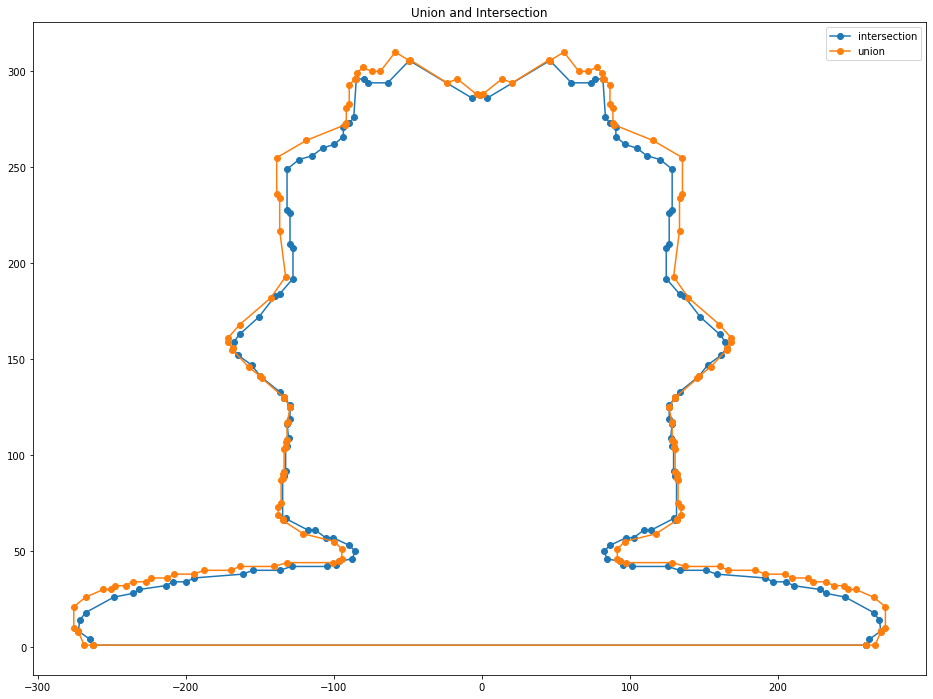

In [11]:
poly1 = Polygon(points_centered)
poly2 = Polygon(flipped)

inter_poly = poly1.intersection(poly2)
union_poly = poly1.union(poly2)

inter = inter_poly.area
union = poly1.area + poly2.area - inter

x,y = inter_poly.exterior.xy
plt.plot(x,y,"-o", label="intersection");
x,y = union_poly.exterior.xy
plt.plot(x,y,"-o", label="union");
plt.title("Union and Intersection");
plt.legend();

iou = inter/union 

In [12]:
print("final score:", iou)

final score: 0.9474595585371353


## Putting it all together

In [15]:
def get_score(img):
    img = img[...,::-1] #Convert BGR to RGB order

    im_R = img[...,0]
    im_G = img[...,1]
    im_B = img[...,2]

    m1 = im_R < 155
    m2 = im_B > 210
    mask = np.logical_and(m1, m2)

    mask = mask.astype(np.uint8)*255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    # get mask contours
    cnts = cv2.findContours(255 - opened,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)[-2]

    #get largest contour
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    # calc arclentgh
    arclen = cv2.arcLength(cnt, True)

    # do polygon approx
    eps = 0.0005
    epsilon = arclen * eps
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    points = approx[:,0].copy()
    # y axis is flipped in image space
    points[:,1] = img.shape[0] - points[:,1]

    max_x, max_y = np.max(points, axis=0)
    min_x, min_y = np.min(points, axis=0)

    mid_x = (max_x + min_x)/2

    points_centered = points - [mid_x, 0]
    flipped = points_centered.copy()
    flipped[:,0] = -flipped[:,0]

    errors = []
    for i in range(len(flipped)):
        start = flipped[i]
        end = flipped[(i + 1) % len(flipped)]
        errors.append(np.linalg.norm(points_centered[0] - start) +
                    np.linalg.norm(np.linalg.norm(points_centered[-1] - end)))

    # plt.plot(errors)
    min_i = np.argmin(errors) + 1
    flipped = np.flip(np.concatenate([flipped[min_i:], flipped[:min_i]]), 0)

    def get_grad(X,Y):
        # D can also be an arbitrary distance matrix: numpy array, shape [m, n]
        D = SquaredEuclidean(X,Y)
        sdtw = SoftDTW(D, gamma=1.0)
        # soft-DTW discrepancy, approaches DTW as gamma -> 0
        value = sdtw.compute()
        # gradient w.r.t. D, shape = [m, n], which is also the expected alignment matrix
        E = sdtw.grad()
        # gradient w.r.t. X, shape = [m, d]
        G = D.jacobian_product(E)
        mean_grad = np.mean(G,0)
        return mean_grad, value

    lr = 0.01
    losses = []
    for i in range(250):
        grad, loss = get_grad(flipped, points_centered)
        losses.append(loss)
        flipped = flipped - [grad[0]*lr,0] #only use x

    poly1 = Polygon(points_centered)
    poly2 = Polygon(flipped)

    inter_poly = poly1.intersection(poly2)
    # union_poly = poly1.union(poly2)

    inter = inter_poly.area
    union = poly1.area + poly2.area - inter

    iou = inter/union
    return iou


vid = cv2.VideoCapture("imgs/example.mp4")

is_good, img = vid.read()
i = 0

ious = []
while is_good:
    iou = get_score(img)
    ious.append(iou)
    print(i, ":", iou, end="\r")

    is_good, img = vid.read()
    i += 1

max_i = np.argmax(ious)
print("best:", max_i, ious[max_i])

min_i = np.argmin(ious)
print("worst:", min_i, ious[min_i])

best: 47 0.9541874304521364
worst: 103 0.8554908116673188


## Since the object is rotating we expect the iou scores to be cyclical

The high frequency fluctuations with a period of about 25 - 50 frames are the different parts of the shape sticking out on either side. The low frequency fluctuation with priod of about 300 frames is the object making a just over a full rotation.

The first peak should match the second last peak.

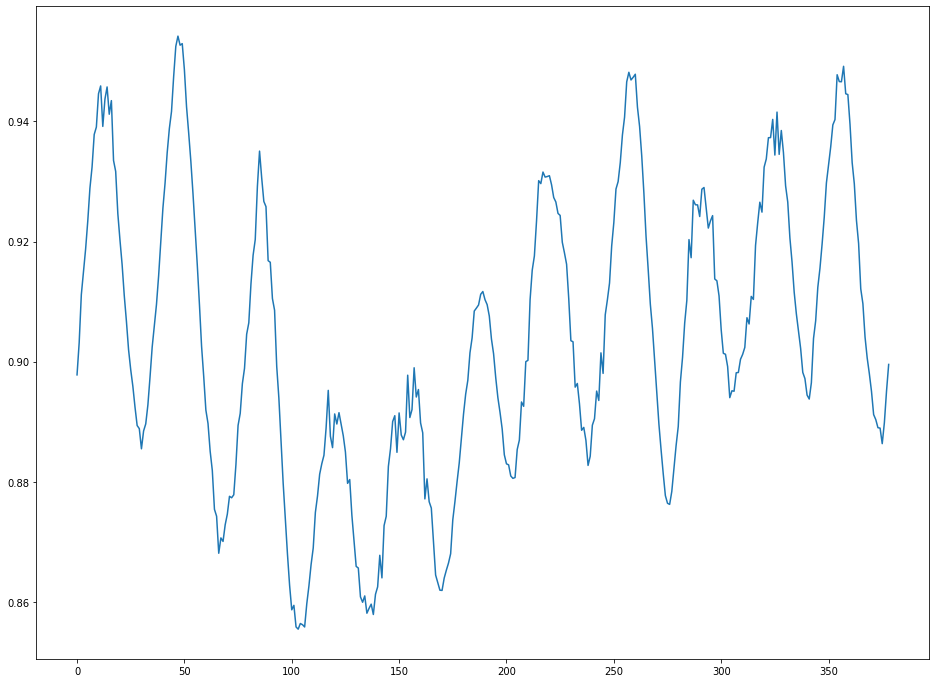

In [16]:
plt.plot(ious)